<h1><center>CS5242 Project</center></h1>

# Table of contents
1. [Problem statement](#problem)
2. [Preprocessing](#preprocessing)
    1. [Data collection](#preprocessing)
    2. [Image Annotation](#annotation)
    3. [Image Augmentation](#augmentation)
    4. [Region proposal](#roi)
    5. [Evaluation metric](#eval)
3. [Neural network models](#model)
    1. [MLP](#mlp)
        1. [Model description](#mlp_description)
        2. [Network structure](#mlp_structure)
        3. [Performance evaluation](#mlp_eval)
    2. [RCNN](#rcnn)
        1. [Model description](#rcnn_description)
        2. [Network structure](#rcnn_structure)
        3. [Performance evaluation](#rcnn_eval)
    3. [RNN](#rnn)
        1. [Model description](#rnn_description)
        2. [Network structure](#rnn_structure)
        3. [Performance evaluation](#rnn_eval)
    4. [ANN](#ann)
        1. [Model description](#ann_description)
        2. [Network structure](#ann_structure)
        3. [Performance evaluation](#ann_eval)
4. [Summary](#summary)
5. [Further related work](#related_work)
6. [Takeaways and future work](#takeaway)
7. [Reference](#ref)

## 1. Problem statement <a name="problem"></a>

The integration of machine learning and vehicular perception enables various active safety measures in autonomous driving. However, numerous issues in a dynamic urban environment, such as suboptimal weather conditions, performance of objection detection, perception and decision making accuracy in autonomous driving, makes it dangerous and costly to collect data from the real world. Therefore, we wish to investigate the feasibility of training vehicle detection via the use of image data generated from video games.

## 2. Preprocessing <a name="preprocessing"></a>

### 2.1. Data collection <a name="preprocessing"></a>
In this work, we aim to collect a traffic image dataset from a 2013 open world video game “Grand Theft Auto V” (GTA V). GTA V has detailed and diverse game scenes, as it’s open world was modelled after the city of Los Angeles. Image dataset can be obtained by recording a gameplay video and converting it into image sequences. 
In detail, we recording a player's playing status of GTA into a video file. Then use convert the video file into image sequences using the code below:

In [ ]:
# Convert video into image sequence
import os
import cv2
import numpy as np
from glob import glob
from random import shuffle

path = 'D:/Github/CS5242_Project/output/'
dst = 'D:/Github/CS5242_Project/Test/'
files = glob(r"D:/Github/CS5242_Project/output\*.jpg")
vidcap = cv2.VideoCapture('Grand Theft Auto V_2021.10.13-00.00_01_1-1.m4v')

def video_to_img():
  success,image = vidcap.read()
  count = 0
  while success:
    cv2.imwrite(os.path.join(path, "%d.jpg" % count), image)   
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

def shuffle_img():
    num_images= len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    arange = np.arange(num_images)
    np.random.shuffle(arange)

    i = 0
    for file in files:
      print('file', str(file))
      os.rename(str(file), os.path.join(dst, str(arange[i] + 1) +'.jpg'))
      i = i+1

In our experiments, we record a 4:52 minutes video data, then convert the video sequence into 8242 images.
Our collected dataset is available here: (https://drive.google.com/drive/folders/1VC1MVYZWxWdbyIPAjdu7vfWq-vLzg06k?usp=sharing). 
Due to the lack of computational resources, our train and test data is as follows:

Data_GTA_test.rar
- train data: 510.jpg - 1010.jpg
- train label: boxes-train-clean.csv
- test data: 1011.jpg - 1510.jpg
- test label: boxes-test-clean.csv

We have seven classes in our labelled training data, namely: [car(1789), bus(57), truck(45), train(6), person(210), traffic light(593), stopsign(10), pottedplant(3)]
And 
 [car(1844), bus(62), truck(37), train(6), person(236), traffic light(615), stopsign(5), pottedplant(3)]
 
A glance of our collected dataset is as follows. It covers the various common traffic scenarios, such as vehicle paralleling, lane changing, pedestrain detection, traffic signal detection, car following, collision warning, etc..

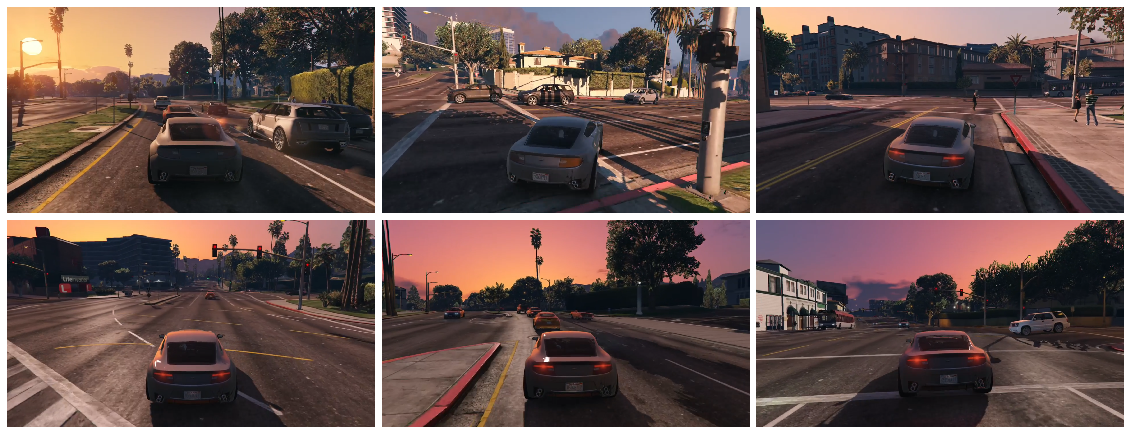

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20, 9))
  
# reading images
Image1 = plt.imread('1.png')
Image2 = plt.imread('2.png')
Image3 = plt.imread('3.png')
Image4 = plt.imread('4.png')
Image5 = plt.imread('5.png')
Image6 = plt.imread('6.png')

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [Image1, Image2, Image3, Image4, Image5, Image6]):
    ax.imshow(im)
    ax.axis('off')
    
plt.show()

### 2.2. Image Annotation<a name="annotation"></a>
To perform supervised learning for vehicle detection, we labelled the data using bounding box annotation, which defines the location of the target vehicle by rectangular boxes.
Inspired by the high-performance of YOLO [1] network in the object detection task, so we feed our collected image datasets into a pre-trained YOLO network (https://pjreddie.com/darknet/yolo/). As the original YOLO source code only returns the prediction, we modified the YOLO source code to return the bounding boxes and used the python script below to preprocess the output into a csv file. 

Each line of the resulting csv file is of the following format:

(class prediction, minimum y (top), minimum x (left), maximum y (bottom), maximum x（right), image file name)


In [ ]:
## The steps for YOLO labelling 
import os
import subprocess

from pdb import set_trace as bp

# Load files from data directory
datadir = "../darknet/Data_GTA/"
os.chdir("../darknet/")

files = os.listdir(datadir)
files = [(int(file.split('.')[0]), file) for file in files]
files.sort()
for _, filename in files:
    print(f"Running darknet on {filename}")
    filepath = os.path.join(datadir, filename)
    process = subprocess.Popen(["./darknet", "detect", "cfg/yolov3.cfg", "yolov3.weights", filepath],
        stdout=subprocess.PIPE, 
        stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    results = stdout.decode("utf-8").split("\n")

    # Remove the first line
    results = results[1:]

    # Write bounding box and labels to file
    with open("/Users/yedanqi/workspace/darknet/boxes.txt", 'w') as fp:
        for idx, val in enumerate(results):
            if val != '':
                if idx % 2 == 0:
                    label = val.split(":")[0]
                    fp.write(label + ",")
                else:
                    fp.write(val)
                    fp.write(f",{filename}\n")

A glance of the labelling results on our collected dataset is as follows:

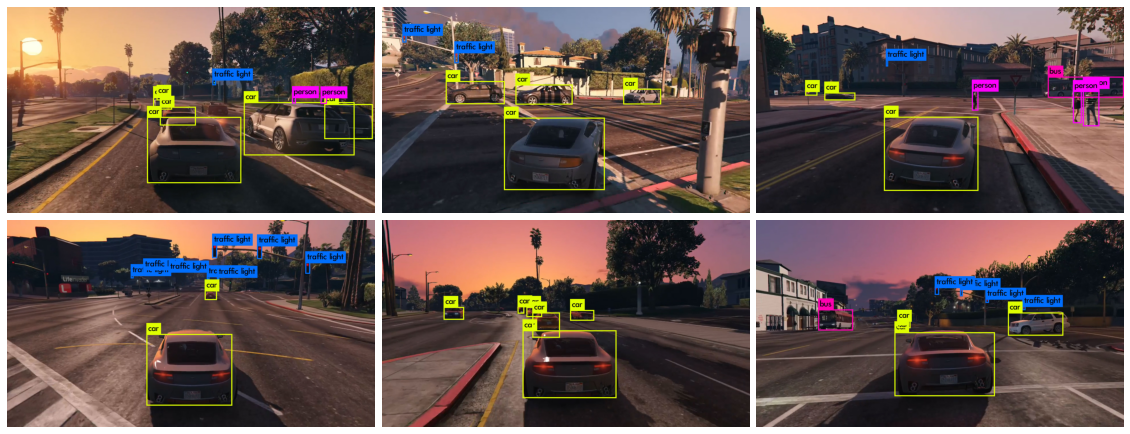

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20, 9))
  
# reading images
Image1 = plt.imread('1_pred.jpg')
Image2 = plt.imread('2_pred.jpg')
Image3 = plt.imread('3_pred.jpg')
Image4 = plt.imread('4_pred.jpg')
Image5 = plt.imread('5_pred.jpg')
Image6 = plt.imread('6_pred.jpg')

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [Image1, Image2, Image3, Image4, Image5, Image6]):
    ax.imshow(im)
    ax.axis('off')
    
plt.show()

## 2.3. Image augmentation<a name="augmentation"></a>
The task of object detection are heavily rely on big data to aviod overfitting. An overfitted model fits too closely to the training set is unable to generalize well on new data. This can be judged if the model produces good results on the seen data(training set) but performs poorly on the unseen data(test set). 
To generalize well from the training data to the reality, it is essential to incorporate data augmentations to create more variability in available data. The following list provides the types of image augmentation methods based on the survey [2].

![augmentation](./augmentation.png)

We will implement the above highlighted method
- Gaussian Blur
- Brightness variation with per-channel probability
- Adding Gaussian Noise with per-channel probability
- Random dropout of pixels
- Examples of image blur, brightness/ color jitter and Dropout are shown below. 



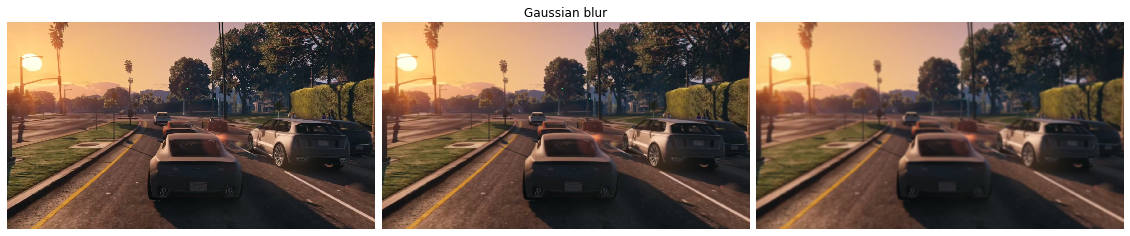

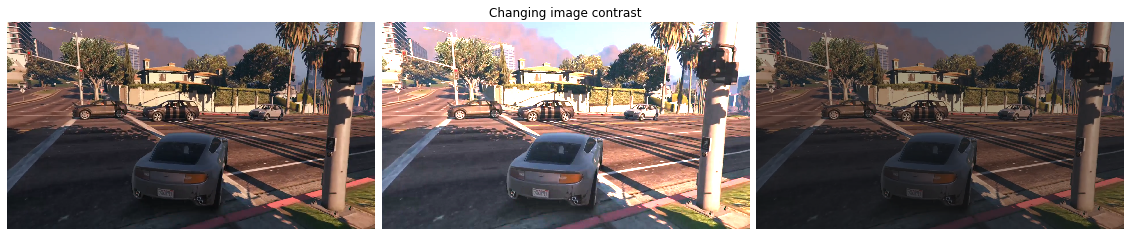

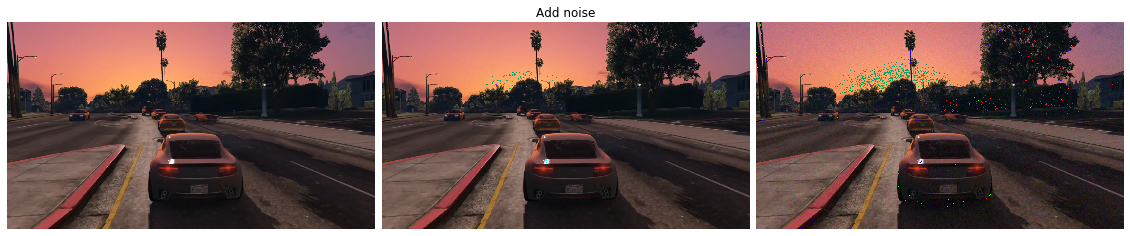

In [88]:
# Augmentation by Gaussian blur
import cv2
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
def gaussian_blur():
    src = cv2.imread('1.png', cv2.IMREAD_UNCHANGED)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    # apply guassian blur on src image
    dst_5 = cv2.GaussianBlur(src,(5, 5), cv2.BORDER_DEFAULT)
    dst_15 = cv2.GaussianBlur(src,(15, 15), cv2.BORDER_DEFAULT)

    fig = plt.figure(figsize=(20, 9))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(1, 3),  
                     axes_pad=0.1)

    grid.axes_all[1].set_title("Gaussian blur")
    for ax, im in zip(grid, [src, dst_5, dst_15]):
        ax.imshow(im)
        ax.axis('off')
    plt.show()

def contrast():
    img = cv2.imread('2.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    contrast = 1.5
    brightness = 10
    # dst(I)=saturate(src1(I)∗alpha+src2(I)∗beta+gamma)。
    # call addWeighted function. use beta = 0 to effectively only operate one one image
    out_dark = cv2.addWeighted( img, 1.5, img, beta=0.2, gamma=10)
    out_light = cv2.addWeighted( img, 0.4, img, beta=0.2, gamma=10)
    #output = cv2.addWeighted
    fig = plt.figure(figsize=(20, 9))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(1, 3),  
                     axes_pad=0.1)

    grid.axes_all[1].set_title("Changing image contrast")
    for ax, im in zip(grid, [img, out_dark, out_light]):
        ax.imshow(im)
        ax.axis('off')
    plt.show()

def add_noise():
    img = cv2.imread('5.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row,col,ch= img.shape
    gauss_1 = np.random.normal(loc=0,scale=1,size=(row,col,ch))
    gauss_2 = np.random.normal(loc=0,scale=5,size=(row,col,ch))
    noisy_1 = img + gauss_1
    noisy_2 = img + gauss_2
    
    fig = plt.figure(figsize=(20, 9))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(1, 3),  
                     axes_pad=0.1)

    grid.axes_all[1].set_title("Add noise")
    for ax, im in zip(grid, [img, noisy_1.astype('uint8'), noisy_2.astype('uint8')]):
        ax.imshow(im)
        ax.axis('off')
    plt.show()

gaussian_blur()
contrast()
add_noise()

## 2.4. Generate Region Proposals<a name="roi"></a>
The heart of the object detection algorithm is not simply recognize whether the target objects are exist in an image. More importantly, it needs to tell where the object is located. For this purpose, we have to select sub-regions (patches) of the image. Then apply the object recognition algorithm to these image patches. The location of the objects is given by the location of the image patches with the highest class probability and Intersection over Union (IoU). 

Region proposal are the sub-regions of an image. It aims to generate a certain amount of candidate bounding boxes to determine the potential objects and their locations in an image. In our experiments, after we generates 200 category-independent region proposals for the input image, then we use neural network models to extract feature vectors from each proposal. 

In our project, regions proposals are generated in the following way:

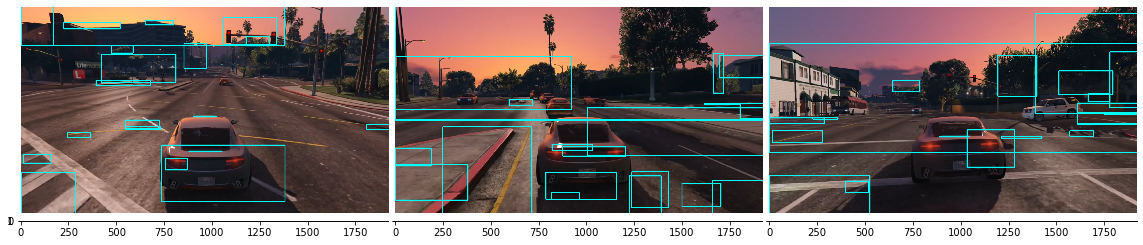

In [87]:
import cv2
from pdb import set_trace as bp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def propose_regions(img, num_regions=20):
    """
    Implementation of selective search for region proposal.
    We use SelectivSearchFast because we try not to bottleneck downstream neural network.
    :param img: Input image.
    :param num_regions: Number of top regions to return. Default is 200.
    """
    segmentor = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    segmentor.setBaseImage(img)
    segmentor.switchToSelectiveSearchFast()
    regions = segmentor.process()

    # Filter regions that are too small
    width, height, _ = img.shape
    filter = []
    for _, _, region_width, region_height in regions:
        filter.append((float(region_width)/width >= 0.1 or float(region_height)/height >= 0.1))

    regions = regions[filter]

    return regions[:num_regions]

def visualize_regions(img, regions):
    """
    Visualize region proposals on an img.
    :param img: Input image.
    :param regions: Region proposals output from propose_regions function.
    """
    # Don't draw on original image
    img_copy = img.copy()
    for x, y, width, height in regions:
        cv2.rectangle(img_copy, (x, y), (x + width, y + height), (0, 250, 250), 3, cv2.LINE_AA)

    return img_copy


img_4 = cv2.imread("4.png")
img_5 = cv2.imread("5.png")
img_6 = cv2.imread("6.png")
# Generate region proposals
regions_4 = propose_regions(img_4)
regions_5 = propose_regions(img_5)
regions_6 = propose_regions(img_6)

# Visualize region proposals
img_4 = cv2.cvtColor(img_4, cv2.COLOR_BGR2RGB)
proposal_img_4 = visualize_regions(img_4, regions_4)
img_5 = cv2.cvtColor(img_5, cv2.COLOR_BGR2RGB)
proposal_img_5 = visualize_regions(img_5, regions_5)
img_6 = cv2.cvtColor(img_6, cv2.COLOR_BGR2RGB)
proposal_img_6 = visualize_regions(img_6, regions_6)


fig = plt.figure(figsize=(20, 9))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 3),  # creates 2x3 grid of axes
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, [proposal_img_4, proposal_img_5, proposal_img_6]):
    ax.imshow(im)
    ax.axis('off')
    
plt.show()

## 2.5. Performance evaluation metrics<a name="eval"></a>

Mean average precision (mAP) is a popular evaluation metric used for object detection (i.e. localisation and classification). Localization determines the location of an instance (e.g. bounding box coordinates) and classification tells you what it is (e.g. car or pedestrain).

To calculate mAP in our object detection task, we first evaluate the intersection over union value (IoU), which measures an overlap between the predicted bounding box and the ground truth bounding box. Besides, the Precision-Recall curve (PR-curve) is used to measure the success of predictions under imblanced classes. Precision is to evaluate the number of predictions that were actually correct (Precision  = $\frac{True Positive}{True Positive + False Positive}$), while recall is to evaluate of the number of truly relevant results (Recall =  $\frac{True Positive}{True Positive + False Negative}$). Under different threshold values, the PR-curve shows the tradeoff between precision and recall. Given an IoU threshold, we can calculate Precision and Recall using IoU value.
Average Precision (AP) is to find the area under the precision-recall curve. The mean Average Precision (mAP) is calculated by taking the mean of AP over all classes and/or overall IoU thresholds. 

In summary: 
- TP = number of detections with $IoU > 0.5$;
- FP = number of detections with $IoU \leq 0.5$ or detected more than once;
- FN = number of objects that are not detected or detected with $IoU \leq 0.5$; 
- Precision = $\frac{TP}{(TP + FP)}$;
- Recall = $\frac{TP}{(TP + FN)}$;  
- PR-curve = Precision and Recall (for each Threshold that is in the Predictions bound-boxes);
- AP = the average precision value for recall value over 0 to 1;
- mAP = the mean of AP over all classes and/or overall IoU thresholds.

In our experiments, we use the implementation of mAP from https://github.com/bes-dev/mean_average_precision 

## 3. Neural Network Models<a name="model"></a>

### 3.1. Regional Multi Layer Perceptron<a name="mlp"></a>

###  3.1.1. Model description <a name="mlp_description"></a>
The first model that we designed was a regional mutilayer perceptron (RMLP) model that drew inspiration from the Fast RCNN paper[] used for object detection. Since object detection is different from classification tasks, we could not simply flatten the image and feed it to RMLP like in the MNIST classification task. To make it suitable for the object detection task, we made the following enhancements:

1. Instead of just a class prediction, we needed to output predictions of bounding box coordinates for each ROI. To do this, the RMLP had two seperate output heads. The first output head (a linear layer of size 1024 x number of classes) does a softmax classification for the class prediction. The second output head (a linear layer of size 1024 x 4) does a regression on the bounding box coordinates of (x, y, width, height).


2. We needed a way to utilize the ROIs generated by selective search to highlight regions where objects were likely to be. For this problem, we introduced the ROI pooling layer (more on this in the next section) from Fast RCNN . 

### 3.1.2 Network structure<a name="mlp_structure"></a>  
The network structure of our MLP network is as follows:
![RMLP](./model.jpeg)

### ROI Pooling

The Region of Interest Pooling (ROI Pooling) layer is a special layer used for object detection tasks, introduced in the Fast RCNN paper. It was introduced as a solution to the problems faced in the original RCNN paper[], whereby a separate model had to be trained on each of the 2000 ROIs proposed by selective search. This made the original RCNN extremely slow and computationally intensive to train. On the contrary, the ROI Pooling layer combined the ROIs and the input image by max pooling over ROIs on the input image to form a fixed-sized feature map. The size of the output feature map is a tunable hyperparameter set to 7x7 in [].

For our RMLP, we applied ROI Pooling on the input image itself. As the input images were not scaled by any convolutional layers, we applied ROI Pooling layers of size 224 x 224 and scale factor of 1. The result is 2000 regional images of size 224 x 224 x 3, which will be flattened as input to the MLP layers.

In [ ]:
### MLP code here
import torch
import torch.nn as nn
from torchvision.ops import RoIPool

class DenseModel(nn.Module):
    """ The custom model for Spot robot """

    def __init__(self, width, height, n_ch, n_class):
        super(DenseModel, self).__init__()

        # ROI max pooling on image itself
        self.roi_pool = RoIPool((7, 7), 1)

        # Get a pseudo size
        input_size = n_ch * 7 * 7

        self.mlp = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(in_features=input_size, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=2048, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )
        
        # This does classification
        self.classifier = nn.Linear(in_features=1024, out_features=n_class)
        # This does bounding box regression
        self.regressor = nn.Linear(in_features=1024, out_features=4)

    def forward(self, img, roi):
        """
        Forward propagation. img is expected to be a tensor of (bs, n_ch, height, width).
        Intention is a tensor of (bs,) and needs to be one hot encoded to (bs,3).
        """
        roi_out = self.roi_pool(img, roi)
        x = torch.flatten(roi_out, start_dim=1)
        logits = self.mlp(x)
        class_pred_logits = self.classifier(logits)
        bbox_pred_logits = self.regressor(logits)
        return class_pred_logits, bbox_pred_logits

### Training with Multi-task Loss

Since the object detection task outputs a classification prediction score and a bounding box prediction, we modified the loss function to combine these two outputs in order for classification and bounding box regression to be trained together. We implemented the multi-task loss as described in [Fast RCNN paper]:
\equation

This loss function is a combination of the softmax cross entropy loss for classification（$L_{cs}$) and the L1 smooth loss for regression ($L_{loc}$). The hyperparameter of $\alpha$ controls the weightage between classification loss and regression loss in the final loss function. We used $\alpha=1$ as in [Fast RCNN paper].

The L1 smooth function is piece-wise function that outputs the mean squared error if the absolute error is less than 1, but outputs a L1 distance if the error is greater than 1. The L1 smooth loss sums over all outputs of the L1 smooth function across all ROIs. This loss was proposed by [Fast RCNN paper] as it was less sensitive to outliers and prevents exploding gradients.

In [ ]:
"""
Custom Loss Functions for Object Detection
"""
import torch
import torch.nn as nn
from pdb import set_trace as bp

class MultiTaskLoss(nn.Module):

    def __init__(self, alpha=1.0):
        """
        Constructor for multi-task loss
        :param alpha: This is actually the lambda hyperparameter that controls 
                    the weight between classification and regression loss.
        """
        super(MultiTaskLoss, self).__init__()
        self.cls_criterion = nn.CrossEntropyLoss()
        self.regression_criterion = nn.SmoothL1Loss()
        self.alpha = alpha
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def forward(self, logits, labels, bbox_pred, bbox_labels):
        """
        Compute the multi-task loss function.
        :param logits: class predictions
        :param labels: ground truth labels of class predictions
        :param bbox_pred: bounding box predictions
        :param bbox_labels: bounding box labels
        """
        L_cls = self.cls_criterion(logits, labels)
        L_loc = self.regression_criterion(bbox_pred, bbox_labels)
        iverson_indicator = (labels > 0).type(torch.LongTensor).to(self.device)

        # Calclutate multi-task loss
        loss = L_cls + (self.alpha * iverson_indicator * L_loc).sum()

        return loss

### 3.1.3 MLP results & Analysis<a name="mlp_eval"></a>  

The performance of MLP lags behind CNN and is deemed insufficient for the object detection task (why).
One disadvantage is that it includes too many parameter. The number of parameters = width x depth x height. Each node is connected to another in a very dense web — resulting in redundancy and inefficiency.
Another adavantage is that MLP takes flattened vectors as input and it disregards the spacial information. 

### 3.2 Regional Convolutional Neural Network<a name="rcnn"></a>

### 3.2.1 Model description<a name="rcnn_description"></a>

One of the main drawback of RMLP model was the lack of a feature extraction block that extracts spatial information that were shift invariant.Therefore, the Regional Convolutional Neural Network (RCNN) was the next logical improvement to RMLP. In our RCNN model, we designed a deep CNN architecture prior to the MLP blocks to extract the features and jointly learns to classify object proposals and refine there spatial locations:

### 3.2.1 Network structure<a name="rcnn_structure"></a>  

![RCNN](sample_model.png)


Instead of applying ROI pooling on the original image, we applied it to the feature map output from the CNN layers. Since the feature maps were scaled in size by the CNN layers, the ROI pooling layer had shapes of 7 x 7 with a scale factor of 1/16. This would generate 2000 pooled feature maps of size 7 x 7 x 3 to be flattened for the subsequent MLP layers for bounding box regression and classification.

In [ ]:
## RCNN code - Implementation
import cv2
import torch
import torch.nn as nn
from torchvision.ops import RoIPool
from preprocess.preprocess import propose_regions
from pdb import set_trace as bp

class RCNN(nn.Module):
    """ Fast Regional Convolutional Neural Network implementation """

    def __init__(self, width, height, n_ch):
        super(RCNN, self).__init__()
        self.convnet = ConvNet(n_ch)

        # Calculate the dimensions after going through self.cnn
        # This will inform scaling factor of ROIPool and in_features size of self.mlp
        test_tensor = torch.rand((1, n_ch, height, width))
        out_tensor = self.convnet(test_tensor)
        _, n_ch, out_height, out_width = out_tensor.size()
        assert height/out_height == width/out_width
        scale_factor = out_height/height
    
        self.roi_pool = RoIPool((7, 7), scale_factor)

        self.classifier = Detector(n_ch * 7 * 7, 6)

    def forward(self, img, roi):
        feature_maps = self.convnet(img)
        roi_out = self.roi_pool(feature_maps, roi)
        roi_out = torch.flatten(roi_out, start_dim=1)
        class_pred, bbox_pred = self.classifier(roi_out)
        return class_pred, bbox_pred

class ConvNet(nn.Module):
    """ The convolution layers for untrained VGG16 """

    def __init__(self, n_ch):
        super(ConvNet, self).__init__()

        # Define the convolution layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_ch, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

    def forward(self, img):
        """
        Forward propagation. img is expected to be a tensor of (bs, n_ch, height, width).
        Intention is a tensor of (bs,) and needs to be one hot encoded to (bs,3).
        """
        feature_maps = self.cnn(img)
        return feature_maps

class Detector(nn.Module):
    """ Neural Network for object detection """

    def __init__(self, input_size, n_class):
        super(Detector, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(in_features=input_size, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True)
        )

        # This does classification
        self.classifier = nn.Linear(in_features=4096, out_features=n_class)
        # This does bounding box regression
        self.regressor = nn.Linear(in_features=4096, out_features=4)

    def forward(self, x):
        """ Predict class and bounding box for each region """
        x = self.mlp(x)
        class_pred_logits = self.classifier(x)
        bbox_pred_logits = self.regressor(x)
        return class_pred_logits, bbox_pred_logits

if __name__ == "__main__":
    img = cv2.imread("data/Data_GTA/0001.jpg")
    regions = propose_regions(img)

    img_tensor = torch.from_numpy(img).type(torch.float32)
    img_tensor = torch.unsqueeze(img_tensor, 0)
    img_tensor = torch.permute(img_tensor, (0, 3, 1, 2))
    regions_tensor = torch.from_numpy(regions).type(torch.float32)

    _, n_ch, height, width = img_tensor.size()
    
    # Test the RCNN
    model = RCNN(width, height, n_ch)

    # ROI Pooling requires boxes to be of Tensor([K, 5]). First column is img index, which is 0 in this example
    img_idx = torch.zeros((200,1))
    boxes = torch.cat((img_idx, regions_tensor), dim=1)

    class_pred, bbox_pred = model(img_tensor, boxes)

    bp()

In [ ]:
## Training
"""
Utility functions for training and testing the individual models
"""
import torch
import time
from torch.utils.data import DataLoader
from preprocess.dataset import ImageDataset
from models.cnn import RCNN
from models.mlp import DenseModel
from models.loss import MultiTaskLoss
from tqdm import tqdm
from pdb import set_trace as bp

def train(model, trainset, model_type='cnn', num_epochs=10, lr=0.1, batch_size=4):
    """
    Trainer for the different models on different datasets
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    criterion = MultiTaskLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):

        running_loss = 0.0
        start_time = time.time()

        for i, (img, rois, bbox, cls) in enumerate(tqdm(train_loader)):
            img, rois, bbox, cls = img.to(device), rois.to(device), bbox.to(device), cls.to(device)

            # Concatenate rois
            for batch_i in range(img.size(0)):

                indices = torch.ones((rois.size(1),1)) * batch_i
                indices = indices.to(device)
                # rois = torch.cat((indices, rois), dim=1)
                if batch_i == 0:
                    cat_rois = rois[batch_i]
                    cat_indices = indices
                    cat_bbox = bbox[batch_i]
                    cat_cls = cls[batch_i]
                else:
                    cat_rois = torch.cat((cat_rois, rois[batch_i]))
                    cat_indices = torch.cat((cat_indices, indices))
                    cat_bbox = torch.cat((cat_bbox, bbox[batch_i]))
                    cat_cls = torch.cat((cat_cls, cls[batch_i]))

            cat_rois = torch.cat((cat_indices, cat_rois), dim=1)
            class_pred, bbox_pred = model(img, cat_rois)
            loss = criterion(class_pred, cat_cls, bbox_pred, cat_bbox)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().item()

            if i % 10 == 0:
                tqdm.write(
                    f"Iteration {i}, Loss: {running_loss/(i + 1)}, Avg iteration time: {(time.time() - start_time)/(i + 1)}s"
                )

        # Save models and metrics
        torch.save(model.state_dict(), f"fast-r{model_type}-epoch{epoch}.pt")
        with open(f"r{model_type}-metrics.txt", 'w+') as fp:
            fp.write(f"Epoch {epoch}, Loss: {running_loss/(i + 1)}")

if __name__ == "__main__":
    width = 1280
    height = 720
    n_ch = 3
    model_type = 'mlp'
    num_classes = 6

    trainset = ImageDataset()

    if model_type == 'cnn':
        model = RCNN(width, height, n_ch)
    elif model_type == 'mlp':
        model = DenseModel(width, height, n_ch, num_classes)

    train(model, trainset, model_type=model_type)

### 3.2.3 Performance evaluation<a name="rcnn_eval"></a>  

In [ ]:
"""
Script for evaluating trained models
"""

import torch
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm

from models.cnn import RCNN
from models.mlp import DenseModel
from preprocess.mAP import average_precision
from preprocess.dataset import ImageDataset

from pdb import set_trace as bp

def evaluate(model, testset, batch_size=2, num_workers=2):
    """
    Evaluates the mean average precision (mAP) of the model given ground truth.
    :param model: A pytorch model to evaluate.
    :param testset: Test set data for evaluation. A pytorch dataset object.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    test_loader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

    for i, (img, rois, bbox, cls) in enumerate(tqdm(test_loader)):
        img, rois, bbox, cls = img.to(device), rois.to(device), bbox.to(device), cls.to(device)

        # Get number of classes for this batch
        num_classes = len(cls.unique())

        # Concatenate rois
        for batch_i in range(img.size(0)):

            indices = torch.ones((rois.size(1),1)) * batch_i
            indices = indices.to(device)
            # rois = torch.cat((indices, rois), dim=1)
            if batch_i == 0:
                cat_rois = rois[batch_i]
                cat_indices = indices
                cat_bbox = bbox[batch_i]
                cat_cls = cls[batch_i]
            else:
                cat_rois = torch.cat((cat_rois, rois[batch_i]))
                cat_indices = torch.cat((cat_indices, indices))
                cat_bbox = torch.cat((cat_bbox, bbox[batch_i]))
                cat_cls = torch.cat((cat_cls, cls[batch_i]))

        cat_rois = torch.cat((cat_indices, cat_rois), dim=1)

        with torch.no_grad():
            class_pred, bbox_pred = model(img, cat_rois)
            class_pred_cls = torch.argmax(class_pred, 1).unsqueeze(1).type(torch.LongTensor)
            class_pred_score = torch.max(torch.softmax(class_pred, dim=1), 1)[0].unsqueeze(1)
            class_pred_cls = class_pred_cls.to(device)
            class_pred_score = class_pred_score.to(device)

            # Prepare preds and ground truth for average precision
            preds = torch.cat((torch.cat((bbox_pred, class_pred_cls), dim=1), class_pred_score), dim=1)
            gt = torch.cat((cat_bbox, cat_cls.unsqueeze(1)), dim=1)

            # Mask of not background in ground truth
            # TODO
            gt_mask = (cat_cls.unsqueeze(1) > 0)

            # Add some extra dimensions for average precision
            difficult = torch.zeros((gt.size(0),1), dtype=torch.float32).to(device)
            gt = torch.cat((gt, difficult), 1)
            crowd = torch.zeros((gt.size(0),1), dtype=torch.float32).to(device)
            gt = torch.cat((gt, crowd), 1)

            # Use only the non background to calculate mAP
            # preds = torch.masked_select(preds, gt_mask)
            # gt = torch.masked_select(gt, gt_mask)

        preds, gt = preds.cpu().numpy(), gt.cpu().numpy()
        
        if i == 0:
            # Batch 0
            ap_score = average_precision(preds, gt, num_classes)
        else:
            ap_score = np.hstack((ap_score, average_precision(preds, gt, num_classes)))
            print(ap_score.shape)

        print(f"Batch {i} mAP: {ap_score.mean()}.")

    bp()
    print(f"Total mAP: {ap_score.mean()}")
    return ap_score.mean()

if __name__ == "__main__":
    width = 1280
    height = 720
    n_ch = 3
    model_type = 'cnn'
    num_classes = 6
    epoch = 38

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if model_type == "cnn":
        model = RCNN(width, height, n_ch)
    elif model_type == "mlp":
        model = DenseModel(width, height, n_ch, num_classes)

    model.load_state_dict(torch.load(f"trained_models/fast-r{model_type}-epoch{epoch}.pt", map_location=device))
    testset = ImageDataset(is_train=False)
    evaluate(model, testset)

## RCNN- Results

Show loss degrade/ results

## Model summary

### Parameters

| Parameter    | Type | Description                      | Options            |
| -------------|------| ---------------------------------| -------------      |
| `n`          |  int |  number of images for training   |      -             |
| `s`          |  int |  number of samples               |      -             |
| `batch`      |  int |  number of batch size            | - |
| `choice`     |  str |  choice which model to run       |`MLP`, `CNN`, `R-CNN`|


### Summary between RMLP and RCNN
- Implement MLP and RCNN on our GTA dataset;
- MLP as baseline, RCNN are expected to improve MLP. 

| Model      	| Number of layers  	| Average Precision   |  mAP               	| Running time  |   Device (cpu/gpu)  |
|-----------	|-------------------	|-------------------- |---------------------|---------------|-------------------	|
| MLP         |                     |                     |                     |               |                     |
| RCNN        |                     |                     |                     |               |                     |

## RNN / ANN here

## Performance Analysis
- Explain the overall performance;
- Why model A is the best?
- Why model B is the worst?
- Compare running time, pros and cons of each model.
- What is the effect of the number of layers to the accuracy of object detection?
- Explain the loss againest iterations;
- Overfitting or Underfitting?
- Future insights 
  - Accurate object detection relies on big data to avoid overfitting, while we have only a limited dataset. To handle this issue, we shall implement several data augmentation algorithms: a data-space solution to the problem of limited data.
  - Most object detection models were trained from relatively ideal scenarios, such as sunny days. Therefore, we will also need to quantify how our model performs under various bad weather conditions: heavy rain, snowy, foggy.

## Agnostic learning 
Perform agnostic study, eg. adding rain drops onto the original dataset; Evaluate its impact on performance.

## 7. Reference<a name="ref"></a>
[1] Redmon, J., Divvala, S., Girshick, R. and Farhadi, A., 2016. You only look once: Unified, real-time object detection. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 779-788).